In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
import torch
from torch import nn
from models.imavae import IMAVAE
from models.metrics import mean_corr_coef as mcc

import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

# To make this notebook's output stable across runs
seed_id = 2020
np.random.seed(seed_id)
torch.manual_seed(seed_id)
torch.cuda.manual_seed(seed_id)
torch.cuda.manual_seed_all(seed_id)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Generate the same synthetic data for case (a) with varying dimensions of Z

We construct the synthetic data for mediation analysis as below:
\begin{align*}
t &\sim \text{Bernoulli}(p) \\
\boldsymbol{z}_m &\sim \mathcal{N}(0, \sigma_m^2 \textbf{I}) + c_1 \mathbb{1}(t = 1) \\
\boldsymbol{x} &= f(\boldsymbol{z}_m) + c_2 \epsilon_{x} \\
y &= \alpha t + \boldsymbol{\beta}^{\text{T}} \boldsymbol{z}_m + \epsilon_{y}
\end{align*}
where $0 < p < 1$ and $c \in \mathbb{R}$ are constants, $f$ is a nonlinear function which is modeled by an **un-trained** multi-layer perceptron (MLP), $\alpha$ and $\beta$ are the coefficients which build a linear relationship between $\boldsymbol{z}$ and $t, \boldsymbol{y}$, and $\epsilon_{x}$ and $\epsilon_{y}$ are Gaussian noise terms.

In [2]:
data = defaultdict(dict)
z_m_dims = [1,2,3,4,5]

for z_m_dim in z_m_dims:
    N = 6000
    p, c1, c2, sigma_m, noise_scale = 0.5, 4, 0.1, 1, 0.1
    x_dim, hidden_dim = 50, 25
    f = nn.Sequential(
        nn.Linear(z_m_dim, hidden_dim), 
        nn.LeakyReLU(), 
        nn.Linear(hidden_dim, x_dim)
    )

    T = np.random.binomial(n=1, p=[p for _ in range(N)]).reshape(-1,1)
    Z_m0 = np.random.multivariate_normal(mean=np.zeros(z_m_dim), cov=sigma_m*np.eye(z_m_dim), size=N)
    Z_m1 = Z_m0 + c1
    Z_m = np.array([Z_m0[i,:] if T[i][0] == 0 else Z_m1[i,:] for i in range(N)])
    with torch.no_grad():
        X = f(torch.tensor(Z_m).float()).numpy()
        X += c2 * np.random.randn(X.shape[0],X.shape[1])
    alpha = np.random.uniform(-2,2,size=1)
    beta = np.random.uniform(-1,1,size=z_m_dim)
    noise = noise_scale * np.random.normal(size=N)
    Y = (alpha * T.reshape(-1) + Z_m @ beta + noise).reshape(-1,1)
    
    scaler = StandardScaler()
    X, Z_m, Y = scaler.fit_transform(X), scaler.fit_transform(Z_m), scaler.fit_transform(Y)
    data[z_m_dim] = {'T': T, 'X': X, 'Z': Z_m, 'Y': Y}

## Fit IMAVAE on the data with corresponding dimensions of Z

In [3]:
num_runs = 5
mcc_metrics_imavae = []

for i in range(num_runs):
    print(f"Run {i+1} \n=========================================")
    mcc_metric = []
    for idx, z_m_dim in enumerate(z_m_dims):
        T, X, Z, Y = data[z_m_dim]['T'], data[z_m_dim]['X'], data[z_m_dim]['Z'], data[z_m_dim]['Y']
        imavae = IMAVAE(n_components=z_m_dim, n_sup_networks=z_m_dim, n_hidden_layers=2, hidden_dim=25, 
                       optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1., anneal=False)
        _ = imavae.fit(
            X, T, Y, X_val=X, aux_val=T, y_val=Y, 
            lr=1e-5, n_epochs=50, pretrain=False, verbose=1, 
            best_model_name="best_model_no_covariate.pt"
        )
        with torch.no_grad():
            t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
            z_m0_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(t0))
            z_m1_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(t1))
            # Estimated z_m for factual outcomes
            z_m_pred = torch.stack([z_m0_pred[i,:] if T[i,0] == 0 else z_m1_pred[i,:] for i in range(N)])
        mcc_metric.append(mcc(Z, z_m_pred.numpy()))
    mcc_metrics_imavae.append(mcc_metric)

Run 1 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.218647, Best Pred Metric [0.543792]


Saving the last epoch with training MSE: 0.218647 and Pred Metric: [0.543792]
Loaded the best model from Epoch: 49 with MSE: 0.218647 and Pred Metric: [0.543792]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.120167, Best Pred Metric [0.8327191


Saving the last epoch with training MSE: 0.120167 and Pred Metric: [0.8327191, 0.8327191]
Loaded the best model from Epoch: 49 with MSE: 0.120167 and Pred Metric: [0.8327191, 0.8327191]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.181526, Best Pred Metric [0.1877718


Saving the last epoch with training MSE: 0.181526 and Pred Metric: [0.18777186, 0.18777186, 0.18777186]
Loaded the best model from Epoch: 49 with MSE: 0.181526 and Pred Metric: [0.18777186, 0.18777186, 0.18777186]
Beginning Training


Epoch: 49, Best Epoch: 48, Best Recon MSE: 0.122357, Best Pred Metric [0.0368971


Saving the last epoch with training MSE: 0.122147 and Pred Metric: [0.0374367, 0.0374367, 0.0374367, 0.0374367]
Loaded the best model from Epoch: 48 with MSE: 0.122357 and Pred Metric: [0.036897145, 0.036897145, 0.036897145, 0.036897145]
Beginning Training


Epoch: 49, Best Epoch: 48, Best Recon MSE: 0.134652, Best Pred Metric [0.0935508


Saving the last epoch with training MSE: 0.13477 and Pred Metric: [0.093689725, 0.093689725, 0.093689725, 0.093689725, 0.093689725]
Loaded the best model from Epoch: 48 with MSE: 0.134652 and Pred Metric: [0.09355086, 0.09355086, 0.09355086, 0.09355086, 0.09355086]
Run 2 
Beginning Training


Epoch: 49, Best Epoch: 48, Best Recon MSE: 0.214577, Best Pred Metric [0.3983898


Saving the last epoch with training MSE: 0.214524 and Pred Metric: [0.39925933]
Loaded the best model from Epoch: 48 with MSE: 0.214577 and Pred Metric: [0.39838982]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.121453, Best Pred Metric [0.0869448


Saving the last epoch with training MSE: 0.121453 and Pred Metric: [0.086944856, 0.086944856]
Loaded the best model from Epoch: 49 with MSE: 0.121453 and Pred Metric: [0.086944856, 0.086944856]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.177217, Best Pred Metric [0.1071766


Saving the last epoch with training MSE: 0.177217 and Pred Metric: [0.107176684, 0.107176684, 0.107176684]
Loaded the best model from Epoch: 49 with MSE: 0.177217 and Pred Metric: [0.107176684, 0.107176684, 0.107176684]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.121487, Best Pred Metric [0.0759582


Saving the last epoch with training MSE: 0.121487 and Pred Metric: [0.07595829, 0.07595829, 0.07595829, 0.07595829]
Loaded the best model from Epoch: 49 with MSE: 0.121487 and Pred Metric: [0.07595829, 0.07595829, 0.07595829, 0.07595829]
Beginning Training


Epoch: 49, Best Epoch: 25, Best Recon MSE: 0.154485, Best Pred Metric [0.1786238


Saving the last epoch with training MSE: 0.147044 and Pred Metric: [0.19817281, 0.19817281, 0.19817281, 0.19817281, 0.19817281]
Loaded the best model from Epoch: 25 with MSE: 0.154485 and Pred Metric: [0.17862384, 0.17862384, 0.17862384, 0.17862384, 0.17862384]
Run 3 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.21755, Best Pred Metric [0.43484366


Saving the last epoch with training MSE: 0.21755 and Pred Metric: [0.43484366]
Loaded the best model from Epoch: 49 with MSE: 0.21755 and Pred Metric: [0.43484366]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.120889, Best Pred Metric [0.0525291


Saving the last epoch with training MSE: 0.120889 and Pred Metric: [0.052529156, 0.052529156]
Loaded the best model from Epoch: 49 with MSE: 0.120889 and Pred Metric: [0.052529156, 0.052529156]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.152927, Best Pred Metric [0.0255356


Saving the last epoch with training MSE: 0.152927 and Pred Metric: [0.02553564, 0.02553564, 0.02553564]
Loaded the best model from Epoch: 49 with MSE: 0.152927 and Pred Metric: [0.02553564, 0.02553564, 0.02553564]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.119283, Best Pred Metric [0.0325148


Saving the last epoch with training MSE: 0.119283 and Pred Metric: [0.032514848, 0.032514848, 0.032514848, 0.032514848]
Loaded the best model from Epoch: 49 with MSE: 0.119283 and Pred Metric: [0.032514848, 0.032514848, 0.032514848, 0.032514848]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.139701, Best Pred Metric [0.3029971


Saving the last epoch with training MSE: 0.139701 and Pred Metric: [0.30299714, 0.30299714, 0.30299714, 0.30299714, 0.30299714]
Loaded the best model from Epoch: 49 with MSE: 0.139701 and Pred Metric: [0.30299714, 0.30299714, 0.30299714, 0.30299714, 0.30299714]
Run 4 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.218396, Best Pred Metric [0.4011652


Saving the last epoch with training MSE: 0.218396 and Pred Metric: [0.40116528]
Loaded the best model from Epoch: 49 with MSE: 0.218396 and Pred Metric: [0.40116528]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.117499, Best Pred Metric [0.0041222


Saving the last epoch with training MSE: 0.117499 and Pred Metric: [0.0041222577, 0.0041222577]
Loaded the best model from Epoch: 49 with MSE: 0.117499 and Pred Metric: [0.0041222577, 0.0041222577]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.181172, Best Pred Metric [0.0997209


Saving the last epoch with training MSE: 0.181172 and Pred Metric: [0.09972094, 0.09972094, 0.09972094]
Loaded the best model from Epoch: 49 with MSE: 0.181172 and Pred Metric: [0.09972094, 0.09972094, 0.09972094]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.117869, Best Pred Metric [0.1549093


Saving the last epoch with training MSE: 0.117869 and Pred Metric: [0.1549093, 0.1549093, 0.1549093, 0.1549093]
Loaded the best model from Epoch: 49 with MSE: 0.117869 and Pred Metric: [0.1549093, 0.1549093, 0.1549093, 0.1549093]
Beginning Training


Epoch: 49, Best Epoch: 44, Best Recon MSE: 0.15726, Best Pred Metric [0.12653169


Saving the last epoch with training MSE: 0.155569 and Pred Metric: [0.13197184, 0.13197184, 0.13197184, 0.13197184, 0.13197184]
Loaded the best model from Epoch: 44 with MSE: 0.15726 and Pred Metric: [0.12653169, 0.12653169, 0.12653169, 0.12653169, 0.12653169]
Run 5 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.216341, Best Pred Metric [0.7067773


Saving the last epoch with training MSE: 0.216341 and Pred Metric: [0.70677733]
Loaded the best model from Epoch: 49 with MSE: 0.216341 and Pred Metric: [0.70677733]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.118336, Best Pred Metric [0.0649766


Saving the last epoch with training MSE: 0.118336 and Pred Metric: [0.064976685, 0.064976685]
Loaded the best model from Epoch: 49 with MSE: 0.118336 and Pred Metric: [0.064976685, 0.064976685]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.18239, Best Pred Metric [0.07434908


Saving the last epoch with training MSE: 0.18239 and Pred Metric: [0.07434908, 0.07434908, 0.07434908]
Loaded the best model from Epoch: 49 with MSE: 0.18239 and Pred Metric: [0.07434908, 0.07434908, 0.07434908]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.121595, Best Pred Metric [0.0495702


Saving the last epoch with training MSE: 0.121595 and Pred Metric: [0.049570262, 0.049570262, 0.049570262, 0.049570262]
Loaded the best model from Epoch: 49 with MSE: 0.121595 and Pred Metric: [0.049570262, 0.049570262, 0.049570262, 0.049570262]
Beginning Training


Epoch: 49, Best Epoch: 48, Best Recon MSE: 0.135843, Best Pred Metric [0.1326991

Saving the last epoch with training MSE: 0.13533 and Pred Metric: [0.13541228, 0.13541228, 0.13541228, 0.13541228, 0.13541228]
Loaded the best model from Epoch: 48 with MSE: 0.135843 and Pred Metric: [0.13269912, 0.13269912, 0.13269912, 0.13269912, 0.13269912]


## Fit regular VAE and $\beta$-VAE with corresponding dimensions of Z

In [4]:
# VAE
num_runs = 5
mcc_metrics_vae = []

for i in range(num_runs):
    print(f"Run {i+1} \n=========================================")
    mcc_metric = []
    for idx, z_m_dim in enumerate(z_m_dims):
        T, X, Z, Y = data[z_m_dim]['T'], data[z_m_dim]['X'], data[z_m_dim]['Z'], data[z_m_dim]['Y']
        imavae = IMAVAE(n_components=z_m_dim, n_sup_networks=z_m_dim, n_hidden_layers=2, hidden_dim=25, 
                        optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1., 
                        identifiable=False, prior_scale=0.01, anneal=False)
        _ = imavae.fit(
            X, T, Y, X_val=X, aux_val=T, y_val=Y, 
            lr=1e-5, n_epochs=50, pretrain=False, verbose=1, 
            best_model_name="best_model_no_covariate.pt"
        )
        with torch.no_grad():
            t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
            z_m0_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
            z_m1_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
            # Estimated z_m for factual outcomes
            z_m_pred = torch.stack([z_m0_pred[i,:] if T[i,0] == 0 else z_m1_pred[i,:] for i in range(N)])
        mcc_metric.append(mcc(Z, z_m_pred.numpy()))
    mcc_metrics_vae.append(mcc_metric)

Run 1 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.240546, Best Pred Metric [0.5268177


Saving the last epoch with training MSE: 0.240546 and Pred Metric: [0.5268177]
Loaded the best model from Epoch: 49 with MSE: 0.240546 and Pred Metric: [0.5268177]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.126874, Best Pred Metric [0.3191992


Saving the last epoch with training MSE: 0.126874 and Pred Metric: [0.31919926, 0.31919926]
Loaded the best model from Epoch: 49 with MSE: 0.126874 and Pred Metric: [0.31919926, 0.31919926]
Beginning Training


Epoch: 49, Best Epoch: 48, Best Recon MSE: 0.197634, Best Pred Metric [0.0474964


Saving the last epoch with training MSE: 0.197459 and Pred Metric: [0.04896524, 0.04896524, 0.04896524]
Loaded the best model from Epoch: 48 with MSE: 0.197634 and Pred Metric: [0.047496423, 0.047496423, 0.047496423]
Beginning Training


Epoch: 49, Best Epoch: 48, Best Recon MSE: 0.137057, Best Pred Metric [0.1852787


Saving the last epoch with training MSE: 0.136489 and Pred Metric: [0.1996534, 0.1996534, 0.1996534, 0.1996534]
Loaded the best model from Epoch: 48 with MSE: 0.137057 and Pred Metric: [0.18527879, 0.18527879, 0.18527879, 0.18527879]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.148485, Best Pred Metric [0.1735536


Saving the last epoch with training MSE: 0.148485 and Pred Metric: [0.17355365, 0.17355365, 0.17355365, 0.17355365, 0.17355365]
Loaded the best model from Epoch: 49 with MSE: 0.148485 and Pred Metric: [0.17355365, 0.17355365, 0.17355365, 0.17355365, 0.17355365]
Run 2 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.232285, Best Pred Metric [0.5333324


Saving the last epoch with training MSE: 0.232285 and Pred Metric: [0.53333247]
Loaded the best model from Epoch: 49 with MSE: 0.232285 and Pred Metric: [0.53333247]
Beginning Training


Epoch: 49, Best Epoch: 48, Best Recon MSE: 0.131711, Best Pred Metric [0.2861959


Saving the last epoch with training MSE: 0.132621 and Pred Metric: [0.3002563, 0.3002563]
Loaded the best model from Epoch: 48 with MSE: 0.131711 and Pred Metric: [0.28619593, 0.28619593]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.191503, Best Pred Metric [0.0632692


Saving the last epoch with training MSE: 0.191503 and Pred Metric: [0.063269205, 0.063269205, 0.063269205]
Loaded the best model from Epoch: 49 with MSE: 0.191503 and Pred Metric: [0.063269205, 0.063269205, 0.063269205]
Beginning Training


Epoch: 49, Best Epoch: 48, Best Recon MSE: 0.15103, Best Pred Metric [0.08066348


Saving the last epoch with training MSE: 0.150072 and Pred Metric: [0.08325636, 0.08325636, 0.08325636, 0.08325636]
Loaded the best model from Epoch: 48 with MSE: 0.15103 and Pred Metric: [0.08066348, 0.08066348, 0.08066348, 0.08066348]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.162805, Best Pred Metric [0.3749379


Saving the last epoch with training MSE: 0.162805 and Pred Metric: [0.37493792, 0.37493792, 0.37493792, 0.37493792, 0.37493792]
Loaded the best model from Epoch: 49 with MSE: 0.162805 and Pred Metric: [0.37493792, 0.37493792, 0.37493792, 0.37493792, 0.37493792]
Run 3 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.247523, Best Pred Metric [0.5490281


Saving the last epoch with training MSE: 0.247523 and Pred Metric: [0.5490281]
Loaded the best model from Epoch: 49 with MSE: 0.247523 and Pred Metric: [0.5490281]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.130554, Best Pred Metric [0.0498597


Saving the last epoch with training MSE: 0.130554 and Pred Metric: [0.04985971, 0.04985971]
Loaded the best model from Epoch: 49 with MSE: 0.130554 and Pred Metric: [0.04985971, 0.04985971]
Beginning Training


Epoch: 49, Best Epoch: 48, Best Recon MSE: 0.196804, Best Pred Metric [0.0560264


Saving the last epoch with training MSE: 0.19715 and Pred Metric: [0.05694987, 0.05694987, 0.05694987]
Loaded the best model from Epoch: 48 with MSE: 0.196804 and Pred Metric: [0.0560264, 0.0560264, 0.0560264]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.126566, Best Pred Metric [0.0898907


Saving the last epoch with training MSE: 0.126566 and Pred Metric: [0.089890786, 0.089890786, 0.089890786, 0.089890786]
Loaded the best model from Epoch: 49 with MSE: 0.126566 and Pred Metric: [0.089890786, 0.089890786, 0.089890786, 0.089890786]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.147373, Best Pred Metric [0.2211161


Saving the last epoch with training MSE: 0.147373 and Pred Metric: [0.22111617, 0.22111617, 0.22111617, 0.22111617, 0.22111617]
Loaded the best model from Epoch: 49 with MSE: 0.147373 and Pred Metric: [0.22111617, 0.22111617, 0.22111617, 0.22111617, 0.22111617]
Run 4 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.232688, Best Pred Metric [0.7474269


Saving the last epoch with training MSE: 0.232688 and Pred Metric: [0.7474269]
Loaded the best model from Epoch: 49 with MSE: 0.232688 and Pred Metric: [0.7474269]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.124688, Best Pred Metric [0.0990999


Saving the last epoch with training MSE: 0.124688 and Pred Metric: [0.09909991, 0.09909991]
Loaded the best model from Epoch: 49 with MSE: 0.124688 and Pred Metric: [0.09909991, 0.09909991]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.205435, Best Pred Metric [0.1354651


Saving the last epoch with training MSE: 0.205435 and Pred Metric: [0.13546515, 0.13546515, 0.13546515]
Loaded the best model from Epoch: 49 with MSE: 0.205435 and Pred Metric: [0.13546515, 0.13546515, 0.13546515]
Beginning Training


Epoch: 49, Best Epoch: 48, Best Recon MSE: 0.136443, Best Pred Metric [0.0692826


Saving the last epoch with training MSE: 0.135539 and Pred Metric: [0.07022982, 0.07022982, 0.07022982, 0.07022982]
Loaded the best model from Epoch: 48 with MSE: 0.136443 and Pred Metric: [0.069282666, 0.069282666, 0.069282666, 0.069282666]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.17388, Best Pred Metric [0.21553846


Saving the last epoch with training MSE: 0.17388 and Pred Metric: [0.21553846, 0.21553846, 0.21553846, 0.21553846, 0.21553846]
Loaded the best model from Epoch: 49 with MSE: 0.17388 and Pred Metric: [0.21553846, 0.21553846, 0.21553846, 0.21553846, 0.21553846]
Run 5 
Beginning Training


Epoch: 49, Best Epoch: 47, Best Recon MSE: 0.236851, Best Pred Metric [0.500298]


Saving the last epoch with training MSE: 0.236641 and Pred Metric: [0.50056314]
Loaded the best model from Epoch: 47 with MSE: 0.236851 and Pred Metric: [0.500298]
Beginning Training


Epoch: 49, Best Epoch: 46, Best Recon MSE: 0.123942, Best Pred Metric [0.0207905


Saving the last epoch with training MSE: 0.122867 and Pred Metric: [0.022098312, 0.022098312]
Loaded the best model from Epoch: 46 with MSE: 0.123942 and Pred Metric: [0.020790577, 0.020790577]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.18978, Best Pred Metric [0.07209657


Saving the last epoch with training MSE: 0.18978 and Pred Metric: [0.07209657, 0.07209657, 0.07209657]
Loaded the best model from Epoch: 49 with MSE: 0.18978 and Pred Metric: [0.07209657, 0.07209657, 0.07209657]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.12791, Best Pred Metric [0.08615295


Saving the last epoch with training MSE: 0.12791 and Pred Metric: [0.086152956, 0.086152956, 0.086152956, 0.086152956]
Loaded the best model from Epoch: 49 with MSE: 0.12791 and Pred Metric: [0.086152956, 0.086152956, 0.086152956, 0.086152956]
Beginning Training


Epoch: 49, Best Epoch: 48, Best Recon MSE: 0.155715, Best Pred Metric [0.1536179

Saving the last epoch with training MSE: 0.155306 and Pred Metric: [0.1591807, 0.1591807, 0.1591807, 0.1591807, 0.1591807]
Loaded the best model from Epoch: 48 with MSE: 0.155715 and Pred Metric: [0.15361793, 0.15361793, 0.15361793, 0.15361793, 0.15361793]


In [5]:
# beta-VAE
num_runs = 5
mcc_metrics_beta_vae = []

for i in range(num_runs):
    print(f"Run {i+1} \n=========================================")
    mcc_metric = []
    for idx, z_m_dim in enumerate(z_m_dims):
        T, X, Z, Y = data[z_m_dim]['T'], data[z_m_dim]['X'], data[z_m_dim]['Z'], data[z_m_dim]['Y']
        imavae = IMAVAE(n_components=z_m_dim, n_sup_networks=z_m_dim, n_hidden_layers=2, hidden_dim=25, 
                        optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1., 
                        identifiable=False, beta=4.0, prior_scale=0.01, anneal=False)
        _ = imavae.fit(
            X, T, Y, X_val=X, aux_val=T, y_val=Y, 
            lr=1e-5, n_epochs=50, pretrain=False, verbose=1, 
            best_model_name="best_model_no_covariate.pt"
        )
        with torch.no_grad():
            t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
            z_m0_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
            z_m1_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
            # Estimated z_m for factual outcomes
            z_m_pred = torch.stack([z_m0_pred[i,:] if T[i,0] == 0 else z_m1_pred[i,:] for i in range(N)])
        mcc_metric.append(mcc(Z, z_m_pred.numpy()))
    mcc_metrics_beta_vae.append(mcc_metric)

Run 1 
Beginning Training


Epoch: 49, Best Epoch: 48, Best Recon MSE: 0.251031, Best Pred Metric [0.5939103


Saving the last epoch with training MSE: 0.251021 and Pred Metric: [0.59940886]
Loaded the best model from Epoch: 48 with MSE: 0.251031 and Pred Metric: [0.59391034]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.153771, Best Pred Metric [0.0680579


Saving the last epoch with training MSE: 0.153771 and Pred Metric: [0.068057984, 0.068057984]
Loaded the best model from Epoch: 49 with MSE: 0.153771 and Pred Metric: [0.068057984, 0.068057984]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.316995, Best Pred Metric [0.2078064


Saving the last epoch with training MSE: 0.316995 and Pred Metric: [0.2078064, 0.2078064, 0.2078064]
Loaded the best model from Epoch: 49 with MSE: 0.316995 and Pred Metric: [0.2078064, 0.2078064, 0.2078064]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.283458, Best Pred Metric [0.1798029


Saving the last epoch with training MSE: 0.283458 and Pred Metric: [0.1798029, 0.1798029, 0.1798029, 0.1798029]
Loaded the best model from Epoch: 49 with MSE: 0.283458 and Pred Metric: [0.1798029, 0.1798029, 0.1798029, 0.1798029]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.33506, Best Pred Metric [0.37892285


Saving the last epoch with training MSE: 0.33506 and Pred Metric: [0.37892285, 0.37892285, 0.37892285, 0.37892285, 0.37892285]
Loaded the best model from Epoch: 49 with MSE: 0.33506 and Pred Metric: [0.37892285, 0.37892285, 0.37892285, 0.37892285, 0.37892285]
Run 2 
Beginning Training


Epoch: 49, Best Epoch: 48, Best Recon MSE: 0.247634, Best Pred Metric [0.5523241


Saving the last epoch with training MSE: 0.247507 and Pred Metric: [0.55325025]
Loaded the best model from Epoch: 48 with MSE: 0.247634 and Pred Metric: [0.5523241]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.162942, Best Pred Metric [0.0485506


Saving the last epoch with training MSE: 0.162942 and Pred Metric: [0.04855068, 0.04855068]
Loaded the best model from Epoch: 49 with MSE: 0.162942 and Pred Metric: [0.04855068, 0.04855068]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.303615, Best Pred Metric [0.4979404


Saving the last epoch with training MSE: 0.303615 and Pred Metric: [0.49794048, 0.49794048, 0.49794048]
Loaded the best model from Epoch: 49 with MSE: 0.303615 and Pred Metric: [0.49794048, 0.49794048, 0.49794048]
Beginning Training


Epoch: 49, Best Epoch: 48, Best Recon MSE: 0.231629, Best Pred Metric [0.0935733


Saving the last epoch with training MSE: 0.231351 and Pred Metric: [0.097916484, 0.097916484, 0.097916484, 0.097916484]
Loaded the best model from Epoch: 48 with MSE: 0.231629 and Pred Metric: [0.09357336, 0.09357336, 0.09357336, 0.09357336]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.347689, Best Pred Metric [0.5302082


Saving the last epoch with training MSE: 0.347689 and Pred Metric: [0.5302082, 0.5302082, 0.5302082, 0.5302082, 0.5302082]
Loaded the best model from Epoch: 49 with MSE: 0.347689 and Pred Metric: [0.5302082, 0.5302082, 0.5302082, 0.5302082, 0.5302082]
Run 3 
Beginning Training


Epoch: 49, Best Epoch: 47, Best Recon MSE: 0.252754, Best Pred Metric [0.5215437


Saving the last epoch with training MSE: 0.251761 and Pred Metric: [0.5326092]
Loaded the best model from Epoch: 47 with MSE: 0.252754 and Pred Metric: [0.5215437]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.178894, Best Pred Metric [0.4993044


Saving the last epoch with training MSE: 0.178894 and Pred Metric: [0.49930447, 0.49930447]
Loaded the best model from Epoch: 49 with MSE: 0.178894 and Pred Metric: [0.49930447, 0.49930447]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.27635, Best Pred Metric [0.09709465


Saving the last epoch with training MSE: 0.27635 and Pred Metric: [0.09709465, 0.09709465, 0.09709465]
Loaded the best model from Epoch: 49 with MSE: 0.27635 and Pred Metric: [0.09709465, 0.09709465, 0.09709465]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.234357, Best Pred Metric [1.3534523


Saving the last epoch with training MSE: 0.234357 and Pred Metric: [1.3534523, 1.3534523, 1.3534523, 1.3534523]
Loaded the best model from Epoch: 49 with MSE: 0.234357 and Pred Metric: [1.3534523, 1.3534523, 1.3534523, 1.3534523]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.343413, Best Pred Metric [0.4108182


Saving the last epoch with training MSE: 0.343413 and Pred Metric: [0.41081828, 0.41081828, 0.41081828, 0.41081828, 0.41081828]
Loaded the best model from Epoch: 49 with MSE: 0.343413 and Pred Metric: [0.41081828, 0.41081828, 0.41081828, 0.41081828, 0.41081828]
Run 4 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.254262, Best Pred Metric [0.5467218


Saving the last epoch with training MSE: 0.254262 and Pred Metric: [0.5467218]
Loaded the best model from Epoch: 49 with MSE: 0.254262 and Pred Metric: [0.5467218]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.196375, Best Pred Metric [0.1329821


Saving the last epoch with training MSE: 0.196375 and Pred Metric: [0.13298213, 0.13298213]
Loaded the best model from Epoch: 49 with MSE: 0.196375 and Pred Metric: [0.13298213, 0.13298213]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.428556, Best Pred Metric [0.2174799


Saving the last epoch with training MSE: 0.428556 and Pred Metric: [0.21747996, 0.21747996, 0.21747996]
Loaded the best model from Epoch: 49 with MSE: 0.428556 and Pred Metric: [0.21747996, 0.21747996, 0.21747996]
Beginning Training


Epoch: 49, Best Epoch: 48, Best Recon MSE: 0.249255, Best Pred Metric [0.1432228


Saving the last epoch with training MSE: 0.248993 and Pred Metric: [0.14504077, 0.14504077, 0.14504077, 0.14504077]
Loaded the best model from Epoch: 48 with MSE: 0.249255 and Pred Metric: [0.14322285, 0.14322285, 0.14322285, 0.14322285]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.339367, Best Pred Metric [0.4068401


Saving the last epoch with training MSE: 0.339367 and Pred Metric: [0.4068401, 0.4068401, 0.4068401, 0.4068401, 0.4068401]
Loaded the best model from Epoch: 49 with MSE: 0.339367 and Pred Metric: [0.4068401, 0.4068401, 0.4068401, 0.4068401, 0.4068401]
Run 5 
Beginning Training


Epoch: 49, Best Epoch: 47, Best Recon MSE: 0.240963, Best Pred Metric [0.5277819


Saving the last epoch with training MSE: 0.240853 and Pred Metric: [0.53235257]
Loaded the best model from Epoch: 47 with MSE: 0.240963 and Pred Metric: [0.52778196]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.165941, Best Pred Metric [0.0581443


Saving the last epoch with training MSE: 0.165941 and Pred Metric: [0.058144316, 0.058144316]
Loaded the best model from Epoch: 49 with MSE: 0.165941 and Pred Metric: [0.058144316, 0.058144316]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.308193, Best Pred Metric [0.0723347


Saving the last epoch with training MSE: 0.308193 and Pred Metric: [0.07233478, 0.07233478, 0.07233478]
Loaded the best model from Epoch: 49 with MSE: 0.308193 and Pred Metric: [0.07233478, 0.07233478, 0.07233478]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.241588, Best Pred Metric [0.1165718


Saving the last epoch with training MSE: 0.241588 and Pred Metric: [0.11657182, 0.11657182, 0.11657182, 0.11657182]
Loaded the best model from Epoch: 49 with MSE: 0.241588 and Pred Metric: [0.11657182, 0.11657182, 0.11657182, 0.11657182]
Beginning Training


Epoch: 49, Best Epoch: 46, Best Recon MSE: 0.34999, Best Pred Metric [0.4209639,

Saving the last epoch with training MSE: 0.343397 and Pred Metric: [0.43677247, 0.43677247, 0.43677247, 0.43677247, 0.43677247]
Loaded the best model from Epoch: 46 with MSE: 0.34999 and Pred Metric: [0.4209639, 0.4209639, 0.4209639, 0.4209639, 0.4209639]


## Compare mean correlation coefficients for varying dimensions of Z

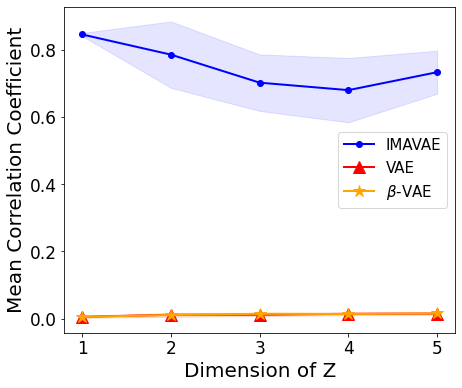

In [7]:
mcc_metrics_imavae = np.array(mcc_metrics_imavae)
mcc_metrics_vae = np.array(mcc_metrics_vae)
mcc_metrics_beta_vae = np.array(mcc_metrics_beta_vae)

fig, ax = plt.subplots(1, 1, figsize=(7,6))
ax.plot(z_m_dims, np.mean(mcc_metrics_imavae,axis=0), color='blue', lw=2, marker='.', markersize=12, label='IMAVAE')
ax.plot(z_m_dims, np.mean(mcc_metrics_vae,axis=0), color='red', lw=2, marker='^', markersize=12, label='VAE')
ax.plot(z_m_dims, np.mean(mcc_metrics_beta_vae,axis=0), color='orange', lw=2, marker='*', markersize=12, label=r'$\beta$-VAE')
ax.fill_between(
    z_m_dims, 
    np.mean(mcc_metrics_imavae,axis=0)-np.std(mcc_metrics_imavae,axis=0), 
    np.mean(mcc_metrics_imavae,axis=0)+np.std(mcc_metrics_imavae,axis=0), 
    color='blue', alpha=0.1
)
ax.fill_between(
    z_m_dims, 
    np.mean(mcc_metrics_vae,axis=0)-np.std(mcc_metrics_vae,axis=0), 
    np.mean(mcc_metrics_vae,axis=0)+np.std(mcc_metrics_vae,axis=0), 
    color='red', alpha=0.1
)
ax.fill_between(
    z_m_dims, 
    np.mean(mcc_metrics_beta_vae,axis=0)-np.std(mcc_metrics_beta_vae,axis=0), 
    np.mean(mcc_metrics_beta_vae,axis=0)+np.std(mcc_metrics_beta_vae,axis=0), 
    color='orange', alpha=0.1
)
ax.locator_params(nbins=5, axis='x')
ax.locator_params(nbins=5, axis='y')
ax.tick_params(axis='both', which='major', labelsize=17)
ax.set_xlabel('Dimension of Z', fontsize=20)
ax.set_ylabel('Mean Correlation Coefficient', fontsize=20)
ax.legend(prop={'size': 15})
plt.savefig('./Figures/mcc_varying_dz_without_covariate.png', dpi=600)

## Fit IMAVAE on the data with different number of training epochs and $d_Z = 2$

In [8]:
num_runs = 5
z_m_dim = 2
mcc_metrics_imavae = []
num_epochs = [5,10,20,40,60,80]

for i in range(num_runs):
    print(f"Run {i+1} \n=========================================")
    mcc_metric = []
    for idx, epochs in enumerate(num_epochs):
        T, X, Z, Y = data[z_m_dim]['T'], data[z_m_dim]['X'], data[z_m_dim]['Z'], data[z_m_dim]['Y']
        imavae = IMAVAE(n_components=z_m_dim, n_sup_networks=z_m_dim, n_hidden_layers=2, hidden_dim=25, 
                        optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1., anneal=False)
        _ = imavae.fit(
            X, T, Y, X_val=X, aux_val=T, y_val=Y, 
            lr=1e-5, n_epochs=epochs, pretrain=False, verbose=1, 
            best_model_name="best_model_no_covariate.pt"
        )
        with torch.no_grad():
            t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
            z_m0_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(t0))
            z_m1_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(t1))
            # Estimated z_m for factual outcomes
            z_m_pred = torch.stack([z_m0_pred[i,:] if T[i,0] == 0 else z_m1_pred[i,:] for i in range(N)])
        mcc_metric.append(mcc(Z, z_m_pred.numpy()))
    mcc_metrics_imavae.append(mcc_metric)

Run 1 
Beginning Training


Epoch: 4, Best Epoch: 1, Best Recon MSE: 0.400842, Best Pred Metric [0.93754715,


Saving the last epoch with training MSE: 0.20767 and Pred Metric: [1.1547401, 1.1547401]
Loaded the best model from Epoch: 1 with MSE: 0.400842 and Pred Metric: [0.93754715, 0.93754715]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.152591, Best Pred Metric [0.95727175,


Saving the last epoch with training MSE: 0.152591 and Pred Metric: [0.95727175, 0.95727175]
Loaded the best model from Epoch: 9 with MSE: 0.152591 and Pred Metric: [0.95727175, 0.95727175]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.139532, Best Pred Metric [0.0179288


Saving the last epoch with training MSE: 0.139532 and Pred Metric: [0.01792881, 0.01792881]
Loaded the best model from Epoch: 19 with MSE: 0.139532 and Pred Metric: [0.01792881, 0.01792881]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.122558, Best Pred Metric [0.407237,


Saving the last epoch with training MSE: 0.122558 and Pred Metric: [0.407237, 0.407237]
Loaded the best model from Epoch: 39 with MSE: 0.122558 and Pred Metric: [0.407237, 0.407237]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.116828, Best Pred Metric [0.1009101


Saving the last epoch with training MSE: 0.116828 and Pred Metric: [0.100910164, 0.100910164]
Loaded the best model from Epoch: 59 with MSE: 0.116828 and Pred Metric: [0.100910164, 0.100910164]
Beginning Training


Epoch: 79, Best Epoch: 78, Best Recon MSE: 0.115181, Best Pred Metric [0.0049274


Saving the last epoch with training MSE: 0.115252 and Pred Metric: [0.005161431, 0.005161431]
Loaded the best model from Epoch: 78 with MSE: 0.115181 and Pred Metric: [0.004927418, 0.004927418]
Run 2 
Beginning Training


Epoch: 4, Best Epoch: 1, Best Recon MSE: 0.456126, Best Pred Metric [1.1642793, 


Saving the last epoch with training MSE: 0.221547 and Pred Metric: [3.0679955, 3.0679955]
Loaded the best model from Epoch: 1 with MSE: 0.456126 and Pred Metric: [1.1642793, 1.1642793]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.153332, Best Pred Metric [1.1103276, 


Saving the last epoch with training MSE: 0.153332 and Pred Metric: [1.1103276, 1.1103276]
Loaded the best model from Epoch: 9 with MSE: 0.153332 and Pred Metric: [1.1103276, 1.1103276]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.125792, Best Pred Metric [0.2658365


Saving the last epoch with training MSE: 0.125792 and Pred Metric: [0.2658365, 0.2658365]
Loaded the best model from Epoch: 19 with MSE: 0.125792 and Pred Metric: [0.2658365, 0.2658365]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.118563, Best Pred Metric [0.0095869


Saving the last epoch with training MSE: 0.118563 and Pred Metric: [0.009586982, 0.009586982]
Loaded the best model from Epoch: 39 with MSE: 0.118563 and Pred Metric: [0.009586982, 0.009586982]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.116909, Best Pred Metric [0.0192679


Saving the last epoch with training MSE: 0.116909 and Pred Metric: [0.019267999, 0.019267999]
Loaded the best model from Epoch: 59 with MSE: 0.116909 and Pred Metric: [0.019267999, 0.019267999]
Beginning Training


Epoch: 79, Best Epoch: 79, Best Recon MSE: 0.116162, Best Pred Metric [0.0061030


Saving the last epoch with training MSE: 0.116162 and Pred Metric: [0.006103068, 0.006103068]
Loaded the best model from Epoch: 79 with MSE: 0.116162 and Pred Metric: [0.006103068, 0.006103068]
Run 3 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.414853, Best Pred Metric [0.13978693,


Saving the last epoch with training MSE: 0.414853 and Pred Metric: [0.13978693, 0.13978693]
Loaded the best model from Epoch: 4 with MSE: 0.414853 and Pred Metric: [0.13978693, 0.13978693]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.159628, Best Pred Metric [0.14453404,


Saving the last epoch with training MSE: 0.159628 and Pred Metric: [0.14453404, 0.14453404]
Loaded the best model from Epoch: 9 with MSE: 0.159628 and Pred Metric: [0.14453404, 0.14453404]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.257951, Best Pred Metric [0.0112091


Saving the last epoch with training MSE: 0.257951 and Pred Metric: [0.011209198, 0.011209198]
Loaded the best model from Epoch: 19 with MSE: 0.257951 and Pred Metric: [0.011209198, 0.011209198]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.253383, Best Pred Metric [0.0361433


Saving the last epoch with training MSE: 0.253383 and Pred Metric: [0.03614332, 0.03614332]
Loaded the best model from Epoch: 39 with MSE: 0.253383 and Pred Metric: [0.03614332, 0.03614332]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.115603, Best Pred Metric [0.0069012


Saving the last epoch with training MSE: 0.115603 and Pred Metric: [0.0069012456, 0.0069012456]
Loaded the best model from Epoch: 59 with MSE: 0.115603 and Pred Metric: [0.0069012456, 0.0069012456]
Beginning Training


Epoch: 79, Best Epoch: 79, Best Recon MSE: 0.115422, Best Pred Metric [0.0099482


Saving the last epoch with training MSE: 0.115422 and Pred Metric: [0.009948215, 0.009948215]
Loaded the best model from Epoch: 79 with MSE: 0.115422 and Pred Metric: [0.009948215, 0.009948215]
Run 4 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.195323, Best Pred Metric [1.9073188, 


Saving the last epoch with training MSE: 0.195323 and Pred Metric: [1.9073188, 1.9073188]
Loaded the best model from Epoch: 4 with MSE: 0.195323 and Pred Metric: [1.9073188, 1.9073188]
Beginning Training


Epoch: 9, Best Epoch: 2, Best Recon MSE: 0.389427, Best Pred Metric [1.0397562, 


Saving the last epoch with training MSE: 0.181933 and Pred Metric: [1.3724859, 1.3724859]
Loaded the best model from Epoch: 2 with MSE: 0.389427 and Pred Metric: [1.0397562, 1.0397562]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.127841, Best Pred Metric [0.7222016


Saving the last epoch with training MSE: 0.127841 and Pred Metric: [0.7222016, 0.7222016]
Loaded the best model from Epoch: 19 with MSE: 0.127841 and Pred Metric: [0.7222016, 0.7222016]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.13103, Best Pred Metric [0.07330411


Saving the last epoch with training MSE: 0.13103 and Pred Metric: [0.07330411, 0.07330411]
Loaded the best model from Epoch: 39 with MSE: 0.13103 and Pred Metric: [0.07330411, 0.07330411]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.117043, Best Pred Metric [0.0078792


Saving the last epoch with training MSE: 0.117043 and Pred Metric: [0.0078792125, 0.0078792125]
Loaded the best model from Epoch: 59 with MSE: 0.117043 and Pred Metric: [0.0078792125, 0.0078792125]
Beginning Training


Epoch: 79, Best Epoch: 79, Best Recon MSE: 0.115114, Best Pred Metric [0.0160856


Saving the last epoch with training MSE: 0.115114 and Pred Metric: [0.016085695, 0.016085695]
Loaded the best model from Epoch: 79 with MSE: 0.115114 and Pred Metric: [0.016085695, 0.016085695]
Run 5 
Beginning Training


Epoch: 4, Best Epoch: 1, Best Recon MSE: 0.502458, Best Pred Metric [0.8461426, 


Saving the last epoch with training MSE: 0.236096 and Pred Metric: [1.5126325, 1.5126325]
Loaded the best model from Epoch: 1 with MSE: 0.502458 and Pred Metric: [0.8461426, 0.8461426]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.167177, Best Pred Metric [0.6363625, 


Saving the last epoch with training MSE: 0.167177 and Pred Metric: [0.6363625, 0.6363625]
Loaded the best model from Epoch: 9 with MSE: 0.167177 and Pred Metric: [0.6363625, 0.6363625]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.142636, Best Pred Metric [0.2352206


Saving the last epoch with training MSE: 0.142636 and Pred Metric: [0.2352206, 0.2352206]
Loaded the best model from Epoch: 19 with MSE: 0.142636 and Pred Metric: [0.2352206, 0.2352206]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.117761, Best Pred Metric [0.0236778


Saving the last epoch with training MSE: 0.117761 and Pred Metric: [0.023677897, 0.023677897]
Loaded the best model from Epoch: 39 with MSE: 0.117761 and Pred Metric: [0.023677897, 0.023677897]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.118675, Best Pred Metric [0.7584427


Saving the last epoch with training MSE: 0.118675 and Pred Metric: [0.7584427, 0.7584427]
Loaded the best model from Epoch: 59 with MSE: 0.118675 and Pred Metric: [0.7584427, 0.7584427]
Beginning Training


Epoch: 79, Best Epoch: 79, Best Recon MSE: 0.11587, Best Pred Metric [0.01182930

Saving the last epoch with training MSE: 0.11587 and Pred Metric: [0.011829309, 0.011829309]
Loaded the best model from Epoch: 79 with MSE: 0.11587 and Pred Metric: [0.011829309, 0.011829309]


## Fit regular VAE and $\beta$-VAE with different number of training epochs and $d_Z = 2$

In [9]:
# VAE
num_runs = 5
z_m_dim = 2
mcc_metrics_vae = []
num_epochs = [5,10,20,40,60,80]

for i in range(num_runs):
    print(f"Run {i+1} \n=========================================")
    mcc_metric = []
    for idx, epochs in enumerate(num_epochs):
        T, X, Z, Y = data[z_m_dim]['T'], data[z_m_dim]['X'], data[z_m_dim]['Z'], data[z_m_dim]['Y']
        imavae = IMAVAE(n_components=z_m_dim, n_sup_networks=z_m_dim, n_hidden_layers=2, hidden_dim=25, 
                        optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1., 
                        identifiable=False, prior_scale=0.01, anneal=False)
        _ = imavae.fit(
            X, T, Y, X_val=X, aux_val=T, y_val=Y, 
            lr=1e-5, n_epochs=epochs, pretrain=False, verbose=1, 
            best_model_name="best_model_no_covariate.pt"
        )
        with torch.no_grad():
            t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
            z_m0_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
            z_m1_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
            # Estimated z_m for factual outcomes
            z_m_pred = torch.stack([z_m0_pred[i,:] if T[i,0] == 0 else z_m1_pred[i,:] for i in range(N)])
        mcc_metric.append(mcc(Z, z_m_pred.numpy()))
    mcc_metrics_vae.append(mcc_metric)

Run 1 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.67372, Best Pred Metric [2.1790338, 2


Saving the last epoch with training MSE: 0.67372 and Pred Metric: [2.1790338, 2.1790338]
Loaded the best model from Epoch: 4 with MSE: 0.67372 and Pred Metric: [2.1790338, 2.1790338]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.41486, Best Pred Metric [1.6377234, 1


Saving the last epoch with training MSE: 0.41486 and Pred Metric: [1.6377234, 1.6377234]
Loaded the best model from Epoch: 9 with MSE: 0.41486 and Pred Metric: [1.6377234, 1.6377234]
Beginning Training


Epoch: 19, Best Epoch: 18, Best Recon MSE: 0.203332, Best Pred Metric [0.8091985


Saving the last epoch with training MSE: 0.198395 and Pred Metric: [0.8721821, 0.8721821]
Loaded the best model from Epoch: 18 with MSE: 0.203332 and Pred Metric: [0.80919856, 0.80919856]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.181613, Best Pred Metric [0.1851413


Saving the last epoch with training MSE: 0.181613 and Pred Metric: [0.18514131, 0.18514131]
Loaded the best model from Epoch: 39 with MSE: 0.181613 and Pred Metric: [0.18514131, 0.18514131]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.123634, Best Pred Metric [0.0383425


Saving the last epoch with training MSE: 0.123634 and Pred Metric: [0.038342595, 0.038342595]
Loaded the best model from Epoch: 59 with MSE: 0.123634 and Pred Metric: [0.038342595, 0.038342595]
Beginning Training


Epoch: 79, Best Epoch: 79, Best Recon MSE: 0.119958, Best Pred Metric [0.0351083


Saving the last epoch with training MSE: 0.119958 and Pred Metric: [0.035108313, 0.035108313]
Loaded the best model from Epoch: 79 with MSE: 0.119958 and Pred Metric: [0.035108313, 0.035108313]
Run 2 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.883106, Best Pred Metric [2.359705, 2


Saving the last epoch with training MSE: 0.883106 and Pred Metric: [2.359705, 2.359705]
Loaded the best model from Epoch: 4 with MSE: 0.883106 and Pred Metric: [2.359705, 2.359705]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.405346, Best Pred Metric [0.44707316,


Saving the last epoch with training MSE: 0.405346 and Pred Metric: [0.44707316, 0.44707316]
Loaded the best model from Epoch: 9 with MSE: 0.405346 and Pred Metric: [0.44707316, 0.44707316]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.349124, Best Pred Metric [0.1582256


Saving the last epoch with training MSE: 0.349124 and Pred Metric: [0.15822564, 0.15822564]
Loaded the best model from Epoch: 19 with MSE: 0.349124 and Pred Metric: [0.15822564, 0.15822564]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.131891, Best Pred Metric [0.0249004


Saving the last epoch with training MSE: 0.131891 and Pred Metric: [0.024900422, 0.024900422]
Loaded the best model from Epoch: 39 with MSE: 0.131891 and Pred Metric: [0.024900422, 0.024900422]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.122513, Best Pred Metric [0.0625608


Saving the last epoch with training MSE: 0.122513 and Pred Metric: [0.062560804, 0.062560804]
Loaded the best model from Epoch: 59 with MSE: 0.122513 and Pred Metric: [0.062560804, 0.062560804]
Beginning Training


Epoch: 79, Best Epoch: 77, Best Recon MSE: 0.12161, Best Pred Metric [0.02601435


Saving the last epoch with training MSE: 0.121383 and Pred Metric: [0.026616374, 0.026616374]
Loaded the best model from Epoch: 77 with MSE: 0.12161 and Pred Metric: [0.026014354, 0.026014354]
Run 3 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.989781, Best Pred Metric [0.86080736,


Saving the last epoch with training MSE: 0.989781 and Pred Metric: [0.86080736, 0.86080736]
Loaded the best model from Epoch: 4 with MSE: 0.989781 and Pred Metric: [0.86080736, 0.86080736]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.399508, Best Pred Metric [0.13490814,


Saving the last epoch with training MSE: 0.399508 and Pred Metric: [0.13490814, 0.13490814]
Loaded the best model from Epoch: 9 with MSE: 0.399508 and Pred Metric: [0.13490814, 0.13490814]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.191712, Best Pred Metric [0.6017816


Saving the last epoch with training MSE: 0.191712 and Pred Metric: [0.60178167, 0.60178167]
Loaded the best model from Epoch: 19 with MSE: 0.191712 and Pred Metric: [0.60178167, 0.60178167]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.132121, Best Pred Metric [0.1192566


Saving the last epoch with training MSE: 0.132121 and Pred Metric: [0.119256645, 0.119256645]
Loaded the best model from Epoch: 39 with MSE: 0.132121 and Pred Metric: [0.119256645, 0.119256645]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.122953, Best Pred Metric [0.0452787


Saving the last epoch with training MSE: 0.122953 and Pred Metric: [0.045278758, 0.045278758]
Loaded the best model from Epoch: 59 with MSE: 0.122953 and Pred Metric: [0.045278758, 0.045278758]
Beginning Training


Epoch: 79, Best Epoch: 79, Best Recon MSE: 0.127142, Best Pred Metric [0.0393463


Saving the last epoch with training MSE: 0.127142 and Pred Metric: [0.039346315, 0.039346315]
Loaded the best model from Epoch: 79 with MSE: 0.127142 and Pred Metric: [0.039346315, 0.039346315]
Run 4 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.901911, Best Pred Metric [1.0756291, 


Saving the last epoch with training MSE: 0.901911 and Pred Metric: [1.0756291, 1.0756291]
Loaded the best model from Epoch: 4 with MSE: 0.901911 and Pred Metric: [1.0756291, 1.0756291]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.406282, Best Pred Metric [0.28166443,


Saving the last epoch with training MSE: 0.406282 and Pred Metric: [0.28166443, 0.28166443]
Loaded the best model from Epoch: 9 with MSE: 0.406282 and Pred Metric: [0.28166443, 0.28166443]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.17564, Best Pred Metric [0.04033811


Saving the last epoch with training MSE: 0.17564 and Pred Metric: [0.04033811, 0.04033811]
Loaded the best model from Epoch: 19 with MSE: 0.17564 and Pred Metric: [0.04033811, 0.04033811]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.128009, Best Pred Metric [0.3301282


Saving the last epoch with training MSE: 0.128009 and Pred Metric: [0.33012828, 0.33012828]
Loaded the best model from Epoch: 39 with MSE: 0.128009 and Pred Metric: [0.33012828, 0.33012828]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.124363, Best Pred Metric [0.0364579


Saving the last epoch with training MSE: 0.124363 and Pred Metric: [0.03645794, 0.03645794]
Loaded the best model from Epoch: 59 with MSE: 0.124363 and Pred Metric: [0.03645794, 0.03645794]
Beginning Training


Epoch: 79, Best Epoch: 77, Best Recon MSE: 0.119841, Best Pred Metric [0.0213345


Saving the last epoch with training MSE: 0.119825 and Pred Metric: [0.021556005, 0.021556005]
Loaded the best model from Epoch: 77 with MSE: 0.119841 and Pred Metric: [0.021334508, 0.021334508]
Run 5 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.988552, Best Pred Metric [1.246139, 1


Saving the last epoch with training MSE: 0.988552 and Pred Metric: [1.246139, 1.246139]
Loaded the best model from Epoch: 4 with MSE: 0.988552 and Pred Metric: [1.246139, 1.246139]
Beginning Training


Epoch: 9, Best Epoch: 7, Best Recon MSE: 0.422511, Best Pred Metric [3.539403, 3


Saving the last epoch with training MSE: 0.40873 and Pred Metric: [3.5966823, 3.5966823]
Loaded the best model from Epoch: 7 with MSE: 0.422511 and Pred Metric: [3.539403, 3.539403]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.188946, Best Pred Metric [0.4932035


Saving the last epoch with training MSE: 0.188946 and Pred Metric: [0.49320352, 0.49320352]
Loaded the best model from Epoch: 19 with MSE: 0.188946 and Pred Metric: [0.49320352, 0.49320352]
Beginning Training


Epoch: 39, Best Epoch: 38, Best Recon MSE: 0.124673, Best Pred Metric [0.0537008


Saving the last epoch with training MSE: 0.124794 and Pred Metric: [0.05572643, 0.05572643]
Loaded the best model from Epoch: 38 with MSE: 0.124673 and Pred Metric: [0.053700887, 0.053700887]
Beginning Training


Epoch: 59, Best Epoch: 57, Best Recon MSE: 0.127716, Best Pred Metric [0.0528178


Saving the last epoch with training MSE: 0.128738 and Pred Metric: [0.052366197, 0.052366197]
Loaded the best model from Epoch: 57 with MSE: 0.127716 and Pred Metric: [0.05281785, 0.05281785]
Beginning Training


Epoch: 79, Best Epoch: 79, Best Recon MSE: 0.121674, Best Pred Metric [0.0391751

Saving the last epoch with training MSE: 0.121674 and Pred Metric: [0.039175116, 0.039175116]
Loaded the best model from Epoch: 79 with MSE: 0.121674 and Pred Metric: [0.039175116, 0.039175116]


In [10]:
# beta-VAE
num_runs = 5
z_m_dim = 2
mcc_metrics_beta_vae = []
num_epochs = [5,10,20,40,60,80]

for i in range(num_runs):
    print(f"Run {i+1} \n=========================================")
    mcc_metric = []
    for idx, epochs in enumerate(num_epochs):
        T, X, Z, Y = data[z_m_dim]['T'], data[z_m_dim]['X'], data[z_m_dim]['Z'], data[z_m_dim]['Y']
        imavae = IMAVAE(n_components=z_m_dim, n_sup_networks=z_m_dim, n_hidden_layers=2, hidden_dim=25, 
                        optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1., 
                        identifiable=False, beta=4.0, prior_scale=0.01, anneal=False)
        _ = imavae.fit(
            X, T, Y, X_val=X, aux_val=T, y_val=Y, 
            lr=1e-5, n_epochs=epochs, pretrain=False, verbose=1, 
            best_model_name="best_model_no_covariate.pt"
        )
        with torch.no_grad():
            t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
            z_m0_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
            z_m1_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
            # Estimated z_m for factual outcomes
            z_m_pred = torch.stack([z_m0_pred[i,:] if T[i,0] == 0 else z_m1_pred[i,:] for i in range(N)])
        mcc_metric.append(mcc(Z, z_m_pred.numpy()))
    mcc_metrics_beta_vae.append(mcc_metric)

Run 1 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.997655, Best Pred Metric [2.4784238, 


Saving the last epoch with training MSE: 0.997655 and Pred Metric: [2.4784238, 2.4784238]
Loaded the best model from Epoch: 4 with MSE: 0.997655 and Pred Metric: [2.4784238, 2.4784238]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.99441, Best Pred Metric [0.93669266, 


Saving the last epoch with training MSE: 0.99441 and Pred Metric: [0.93669266, 0.93669266]
Loaded the best model from Epoch: 9 with MSE: 0.99441 and Pred Metric: [0.93669266, 0.93669266]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.447851, Best Pred Metric [0.4690973


Saving the last epoch with training MSE: 0.447851 and Pred Metric: [0.4690973, 0.4690973]
Loaded the best model from Epoch: 19 with MSE: 0.447851 and Pred Metric: [0.4690973, 0.4690973]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.343999, Best Pred Metric [0.1685825


Saving the last epoch with training MSE: 0.343999 and Pred Metric: [0.16858257, 0.16858257]
Loaded the best model from Epoch: 39 with MSE: 0.343999 and Pred Metric: [0.16858257, 0.16858257]
Beginning Training


Epoch: 59, Best Epoch: 58, Best Recon MSE: 0.203905, Best Pred Metric [0.0889007


Saving the last epoch with training MSE: 0.209041 and Pred Metric: [0.09346828, 0.09346828]
Loaded the best model from Epoch: 58 with MSE: 0.203905 and Pred Metric: [0.088900775, 0.088900775]
Beginning Training


Epoch: 79, Best Epoch: 77, Best Recon MSE: 0.179566, Best Pred Metric [0.0584599


Saving the last epoch with training MSE: 0.179997 and Pred Metric: [0.059729524, 0.059729524]
Loaded the best model from Epoch: 77 with MSE: 0.179566 and Pred Metric: [0.05845997, 0.05845997]
Run 2 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.999868, Best Pred Metric [1.5633662, 


Saving the last epoch with training MSE: 0.999868 and Pred Metric: [1.5633662, 1.5633662]
Loaded the best model from Epoch: 4 with MSE: 0.999868 and Pred Metric: [1.5633662, 1.5633662]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.999996, Best Pred Metric [1.125618, 1


Saving the last epoch with training MSE: 0.999996 and Pred Metric: [1.125618, 1.125618]
Loaded the best model from Epoch: 9 with MSE: 0.999996 and Pred Metric: [1.125618, 1.125618]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.428661, Best Pred Metric [1.4750384


Saving the last epoch with training MSE: 0.428661 and Pred Metric: [1.4750384, 1.4750384]
Loaded the best model from Epoch: 19 with MSE: 0.428661 and Pred Metric: [1.4750384, 1.4750384]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.196001, Best Pred Metric [0.1740646


Saving the last epoch with training MSE: 0.196001 and Pred Metric: [0.17406464, 0.17406464]
Loaded the best model from Epoch: 39 with MSE: 0.196001 and Pred Metric: [0.17406464, 0.17406464]
Beginning Training


Epoch: 59, Best Epoch: 58, Best Recon MSE: 0.153356, Best Pred Metric [0.1229374


Saving the last epoch with training MSE: 0.154187 and Pred Metric: [0.12243984, 0.12243984]
Loaded the best model from Epoch: 58 with MSE: 0.153356 and Pred Metric: [0.122937426, 0.122937426]
Beginning Training


Epoch: 79, Best Epoch: 79, Best Recon MSE: 0.136562, Best Pred Metric [0.0403814


Saving the last epoch with training MSE: 0.136562 and Pred Metric: [0.04038144, 0.04038144]
Loaded the best model from Epoch: 79 with MSE: 0.136562 and Pred Metric: [0.04038144, 0.04038144]
Run 3 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.997381, Best Pred Metric [1.7087717, 


Saving the last epoch with training MSE: 0.997381 and Pred Metric: [1.7087717, 1.7087717]
Loaded the best model from Epoch: 4 with MSE: 0.997381 and Pred Metric: [1.7087717, 1.7087717]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.99517, Best Pred Metric [0.53011703, 


Saving the last epoch with training MSE: 0.99517 and Pred Metric: [0.53011703, 0.53011703]
Loaded the best model from Epoch: 9 with MSE: 0.99517 and Pred Metric: [0.53011703, 0.53011703]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.401546, Best Pred Metric [0.2055059


Saving the last epoch with training MSE: 0.401546 and Pred Metric: [0.20550594, 0.20550594]
Loaded the best model from Epoch: 19 with MSE: 0.401546 and Pred Metric: [0.20550594, 0.20550594]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.184397, Best Pred Metric [0.1674019


Saving the last epoch with training MSE: 0.184397 and Pred Metric: [0.16740194, 0.16740194]
Loaded the best model from Epoch: 39 with MSE: 0.184397 and Pred Metric: [0.16740194, 0.16740194]
Beginning Training


Epoch: 59, Best Epoch: 58, Best Recon MSE: 0.152877, Best Pred Metric [0.0504713


Saving the last epoch with training MSE: 0.157711 and Pred Metric: [0.05252308, 0.05252308]
Loaded the best model from Epoch: 58 with MSE: 0.152877 and Pred Metric: [0.050471313, 0.050471313]
Beginning Training


Epoch: 79, Best Epoch: 79, Best Recon MSE: 0.130121, Best Pred Metric [0.0638233


Saving the last epoch with training MSE: 0.130121 and Pred Metric: [0.06382334, 0.06382334]
Loaded the best model from Epoch: 79 with MSE: 0.130121 and Pred Metric: [0.06382334, 0.06382334]
Run 4 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.999333, Best Pred Metric [0.5428192, 


Saving the last epoch with training MSE: 0.999333 and Pred Metric: [0.5428192, 0.5428192]
Loaded the best model from Epoch: 4 with MSE: 0.999333 and Pred Metric: [0.5428192, 0.5428192]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.9998, Best Pred Metric [0.24205685, 0


Saving the last epoch with training MSE: 0.9998 and Pred Metric: [0.24205685, 0.24205685]
Loaded the best model from Epoch: 9 with MSE: 0.9998 and Pred Metric: [0.24205685, 0.24205685]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.399773, Best Pred Metric [0.1036332


Saving the last epoch with training MSE: 0.399773 and Pred Metric: [0.10363322, 0.10363322]
Loaded the best model from Epoch: 19 with MSE: 0.399773 and Pred Metric: [0.10363322, 0.10363322]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.194857, Best Pred Metric [0.2479535


Saving the last epoch with training MSE: 0.194857 and Pred Metric: [0.24795355, 0.24795355]
Loaded the best model from Epoch: 39 with MSE: 0.194857 and Pred Metric: [0.24795355, 0.24795355]
Beginning Training


Epoch: 59, Best Epoch: 58, Best Recon MSE: 0.146729, Best Pred Metric [0.0698109


Saving the last epoch with training MSE: 0.146613 and Pred Metric: [0.069949776, 0.069949776]
Loaded the best model from Epoch: 58 with MSE: 0.146729 and Pred Metric: [0.069810934, 0.069810934]
Beginning Training


Epoch: 79, Best Epoch: 79, Best Recon MSE: 0.153068, Best Pred Metric [0.0521722


Saving the last epoch with training MSE: 0.153068 and Pred Metric: [0.05217228, 0.05217228]
Loaded the best model from Epoch: 79 with MSE: 0.153068 and Pred Metric: [0.05217228, 0.05217228]
Run 5 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 1.00234, Best Pred Metric [1.6176536, 1


Saving the last epoch with training MSE: 1.00234 and Pred Metric: [1.6176536, 1.6176536]
Loaded the best model from Epoch: 4 with MSE: 1.00234 and Pred Metric: [1.6176536, 1.6176536]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.99895, Best Pred Metric [2.541796, 2.


Saving the last epoch with training MSE: 0.99895 and Pred Metric: [2.541796, 2.541796]
Loaded the best model from Epoch: 9 with MSE: 0.99895 and Pred Metric: [2.541796, 2.541796]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.407594, Best Pred Metric [1.701209,


Saving the last epoch with training MSE: 0.407594 and Pred Metric: [1.701209, 1.701209]
Loaded the best model from Epoch: 19 with MSE: 0.407594 and Pred Metric: [1.701209, 1.701209]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.352178, Best Pred Metric [1.0523124


Saving the last epoch with training MSE: 0.352178 and Pred Metric: [1.0523124, 1.0523124]
Loaded the best model from Epoch: 39 with MSE: 0.352178 and Pred Metric: [1.0523124, 1.0523124]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.150194, Best Pred Metric [0.0797449


Saving the last epoch with training MSE: 0.150194 and Pred Metric: [0.07974498, 0.07974498]
Loaded the best model from Epoch: 59 with MSE: 0.150194 and Pred Metric: [0.07974498, 0.07974498]
Beginning Training


Epoch: 79, Best Epoch: 79, Best Recon MSE: 0.134129, Best Pred Metric [0.0384808

Saving the last epoch with training MSE: 0.134129 and Pred Metric: [0.038480822, 0.038480822]
Loaded the best model from Epoch: 79 with MSE: 0.134129 and Pred Metric: [0.038480822, 0.038480822]


## Compare mean correlation coefficients for varying number of training epochs

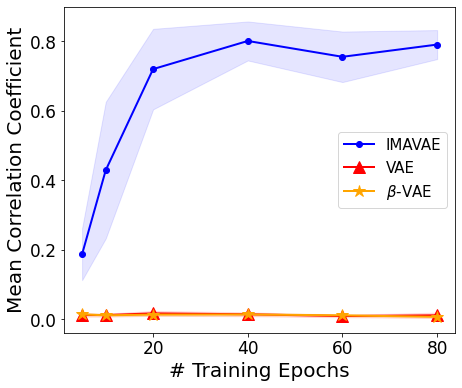

In [11]:
mcc_metrics_imavae = np.array(mcc_metrics_imavae)
mcc_metrics_vae = np.array(mcc_metrics_vae)
mcc_metrics_beta_vae = np.array(mcc_metrics_beta_vae)

fig, ax = plt.subplots(1, 1, figsize=(7,6))
ax.plot(num_epochs, np.mean(mcc_metrics_imavae,axis=0), color='blue', lw=2, marker='.', markersize=12, label='IMAVAE')
ax.plot(num_epochs, np.mean(mcc_metrics_vae,axis=0), color='red', lw=2, marker='^', markersize=12, label='VAE')
ax.plot(num_epochs, np.mean(mcc_metrics_beta_vae,axis=0), color='orange', lw=2, marker='*', markersize=12, label=r'$\beta$-VAE')
ax.fill_between(
    num_epochs, 
    np.mean(mcc_metrics_imavae,axis=0)-np.std(mcc_metrics_imavae,axis=0), 
    np.mean(mcc_metrics_imavae,axis=0)+np.std(mcc_metrics_imavae,axis=0), 
    color='blue', alpha=0.1
)
ax.fill_between(
    num_epochs, 
    np.mean(mcc_metrics_vae,axis=0)-np.std(mcc_metrics_vae,axis=0), 
    np.mean(mcc_metrics_vae,axis=0)+np.std(mcc_metrics_vae,axis=0), 
    color='red', alpha=0.1
)
ax.fill_between(
    num_epochs, 
    np.mean(mcc_metrics_beta_vae,axis=0)-np.std(mcc_metrics_beta_vae,axis=0), 
    np.mean(mcc_metrics_beta_vae,axis=0)+np.std(mcc_metrics_beta_vae,axis=0), 
    color='orange', alpha=0.1
)
ax.locator_params(nbins=5, axis='y')
ax.tick_params(axis='both', which='major', labelsize=17)
ax.set_xlabel('# Training Epochs', fontsize=20)
ax.set_ylabel('Mean Correlation Coefficient', fontsize=20)
ax.legend(prop={'size': 15})
plt.savefig('./Figures/mcc_varying_epochs_without_covariate.png', dpi=600)